# **Konfigurasi Colab dan download dataset**

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Dataset/Kaggle"

In [44]:
#changing the working directory
%cd /content/drive/My Drive/Dataset/Kaggle

/content/drive/My Drive/Dataset/Kaggle


In [45]:
!kaggle datasets download -d uciml/news-aggregator-dataset

news-aggregator-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [46]:
!unzip news-aggregator-dataset.zip -d '/content/drive/My Drive/Dicoding/Submission_1/dataset'

Archive:  news-aggregator-dataset.zip
replace /content/drive/My Drive/Dicoding/Submission_1/dataset/uci-news-aggregator.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [47]:
dataset = '/content/drive/My Drive/Dicoding/Submission_1/dataset/uci-news-aggregator.csv'

# **Import Libary**

In [48]:
import os
import re, string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

# **Define Function**

In [49]:
sns.set(style="darkgrid")

# Plot Kategori Distribusi
def plot_distribusi_kategori(title, df):
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.set_title(title)
  ax.set_xlabel('Total')
  sns.countplot(ax=ax, y="CATEGORY", 
                data=df, color='green', 
                order = df['CATEGORY'].value_counts().index, 
                saturation=0.5)

In [50]:
# Plot Distribusi Kolom
def plot_distribusi_kolom(title, df, kolom):
  category = df["CATEGORY"].unique()
  average = []

  for i in category:
    average.append(np.mean(df[df["CATEGORY"] == i][kolom].apply(lambda x : len(x.split()))))

  df_average = pd.DataFrame({
      "CATEGORY" : category,
      "average": average
      })

  sns.set(style="darkgrid")
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.set_title(title)
  ax.set_xlabel('Total')
  sns.barplot(y="CATEGORY", x="average",
              order = df_average.sort_values('average', ascending=False)['CATEGORY'],  
              data=df_average, color='green', saturation=0.5)

# **Eksplorasi Data**

In [74]:
data = pd.read_csv(dataset)
display(data.head())
print('Jumlah sampel data : {}'.format(data.shape[0]))
print('Jumlah fitur/kolom : {}'.format(data.shape[1]))

print('Jumlah null data :\n', data.isnull().sum())

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


Jumlah sampel data : 422419
Jumlah fitur/kolom : 8
Jumlah null data :
 ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64


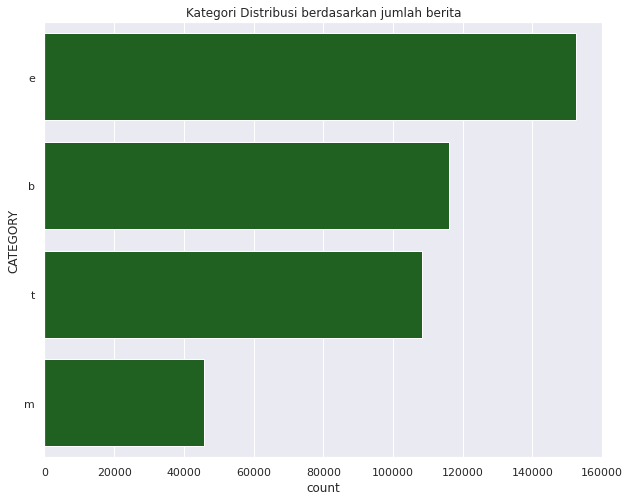

In [75]:
plot_distribusi_kategori('Kategori Distribusi berdasarkan jumlah berita', data)

Ubah nama kategori

In [76]:
data['CATEGORY'] = data['CATEGORY'].replace({
    'b' : 'business',
    't' : 'science and technology',
    'e' : 'entertainment',
    'm' : 'health'
})

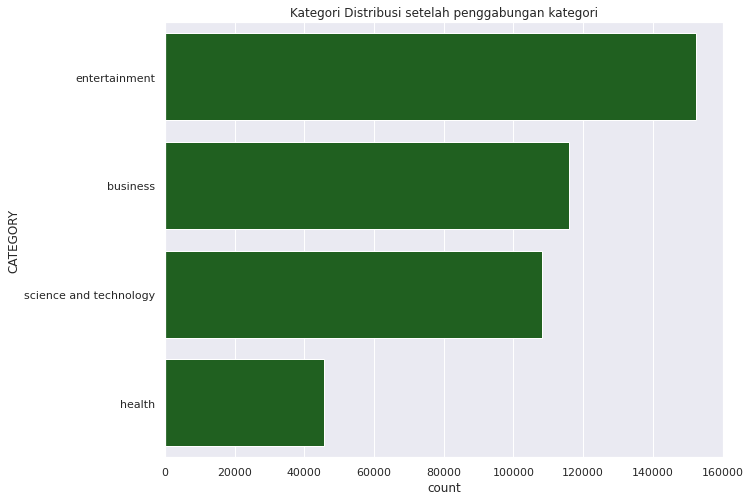

In [77]:
plot_distribusi_kategori('Kategori Distribusi setelah penggabungan kategori', data)

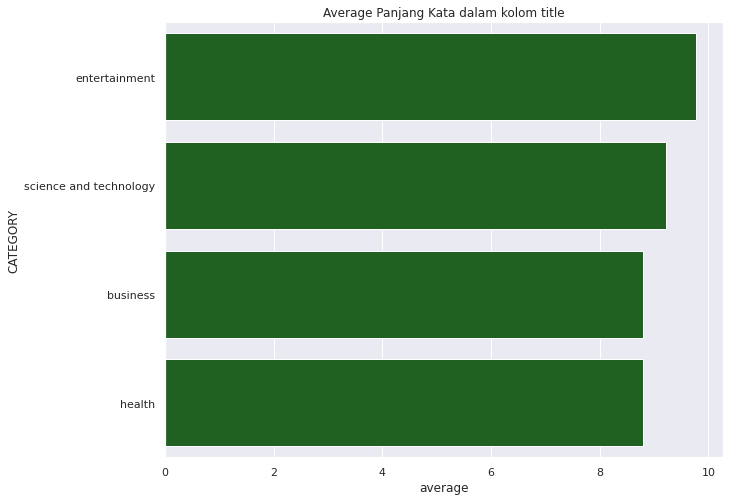

In [78]:
plot_distribusi_kolom('Average Panjang Kata dalam kolom title', data, 'TITLE')

# **Preparing Data**

Memilih jumlah maksimal kategori paling banyak

In [79]:
# Mengambil maksimum data dari setiap kategori
num_of_categories = 35000

# Mengacak datafram
shuffled = data.reindex(np.random.permutation(data.index))
# memecah setiap kategori sebanyak maks 45000
business = shuffled[shuffled['CATEGORY'] == 'business'][:num_of_categories]
science = shuffled[shuffled['CATEGORY'] == 'science and technology'][:num_of_categories]
entertainment = shuffled[shuffled['CATEGORY'] == 'entertainment'][:num_of_categories]
health = shuffled[shuffled['CATEGORY'] == 'health'][:num_of_categories]
# menggabungkan semua kategori
data = pd.concat([business,science,entertainment,health], ignore_index=True)
# mengacak ulang datafram
data = data.reindex(np.random.permutation(data.index))

In [80]:
# Ubah kategori ke bentuk id atau angka
categories = data.groupby('CATEGORY').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

data['c2id'] = data['CATEGORY'].apply(lambda x: category_int[x])

In [81]:
# panjang kata
n_most_common_words = 8000

# Tokenizing
tokenizer = Tokenizer(num_words=n_most_common_words, filters=string.punctuation, lower=True)
tokenizer.fit_on_texts(data['TITLE'])
X = tokenizer.texts_to_sequences(data['TITLE'])
data['words'] = X

data['word_length'] = data.words.apply(lambda i: len(i))

In [82]:
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,c2id,words,word_length
104779,265903,The 'Caged Bird' flies away: Maya Angelou dies...,http://www.allvoices.com/contributed-news/1716...,allvoices,entertainment,dXLpCHn5emGL4GM6g6reuFkybVpJM,www.allvoices.com,1401367707471,1,"[4, 1236, 3005, 879, 3035, 3305, 215, 12, 5575]",9
98308,375846,George RR Martin: 'F*ck You' to All These Hate...,http://observer.com/2014/07/george-r-r-martin-...,New York Observer,entertainment,dE5UN5fidBqfgyMUVcQdhUTnmLK0M,observer.com,1404980650829,1,"[586, 3471, 638, 1489, 39, 1, 111, 1657, 6885,...",10
84495,107179,Outkast Runs Out of Time at Their Coachella Re...,http://www.ryot.org/outkast-runs-time-coachell...,RYOT,entertainment,dT2dmWRF_A6k7aM1TxZxVdOnsBF9M,www.ryot.org,1397355564395,1,"[4941, 4346, 48, 5, 74, 12, 223, 1183, 2669, 1...",15
135398,191281,Massachusetts family objects to plan for daugh...,http://www.pressherald.com/news/nationworld/Fa...,Press Herald,health,d3UMkqG23UtrGBM2kQxOIgf4FGDsM,www.pressherald.com,1399512497766,2,"[2194, 403, 1682, 1, 282, 6, 1145, 2, 238, 1453]",10
127344,59503,CDC Reports New Cases of Heartland Virus,http://www.medpagetoday.com/InfectiousDisease/...,MedPage Today,health,dBoEV5cpvG8fCTMDkxZSGnwCIc28M,www.medpagetoday.com,1396023121568,2,"[243, 198, 11, 171, 5, 73]",6


## **Split Data**

In [83]:
# maks panjang padding
max_len = 150
features = pad_sequences(data.words, maxlen=max_len)
labels = np_utils.to_categorical(list(data.c2id))
data_train, data_test, label_train, label_test = train_test_split(features, labels, test_size=0.2, random_state=42)
data_train_1, data_test_1, label_train_1, label_test_1 = train_test_split(data, labels, test_size=0.2, random_state=42)

# **Plot Distribusi Data Training dan Testing**

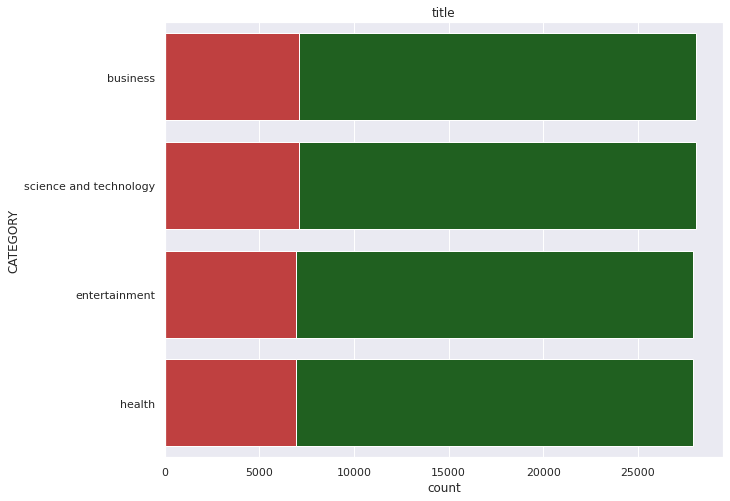

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('title')
ax.set_xlabel('Total')
sns.countplot(ax=ax, y="CATEGORY", 
              data=data_train_1, color='green', 
              order = data_train_1['CATEGORY'].value_counts().index, 
              saturation=0.5)
sns.countplot(ax=ax, y="CATEGORY", 
              data=data_test_1, color='red', 
              order = data_test_1['CATEGORY'].value_counts().index, 
              saturation=0.5)

(112000, 130)

# **Build Model**

In [85]:
BATCH_SIZE = 256
EPOCHS = 25
emb_dim = 128

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=data_train.shape[1]))
model.add(SpatialDropout1D(0.4, ))
model.add(LSTM(32, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(64, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 150, 128)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 150, 32)           20608     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 4)                

In [86]:
history = model.fit(
  data_train, 
  label_train, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  validation_split=0.2,
  callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)]
)

Epoch 1/25
350/350 [==============================] - 211s 604ms/step - loss: 0.5874 - accuracy: 0.7571 - val_loss: 0.2586 - val_accuracy: 0.9093
Epoch 2/25
350/350 [==============================] - 209s 597ms/step - loss: 0.2365 - accuracy: 0.9184 - val_loss: 0.2303 - val_accuracy: 0.9197
Epoch 3/25
350/350 [==============================] - 207s 592ms/step - loss: 0.1974 - accuracy: 0.9312 - val_loss: 0.2373 - val_accuracy: 0.9200
Epoch 4/25
350/350 [==============================] - 208s 593ms/step - loss: 0.1791 - accuracy: 0.9370 - val_loss: 0.2264 - val_accuracy: 0.9215
Epoch 5/25
350/350 [==============================] - 206s 590ms/step - loss: 0.1645 - accuracy: 0.9419 - val_loss: 0.2257 - val_accuracy: 0.9227
Epoch 6/25
350/350 [==============================] - 206s 588ms/step - loss: 0.1553 - accuracy: 0.9446 - val_loss: 0.2295 - val_accuracy: 0.9217
Epoch 7/25
350/350 [==============================] - 207s 591ms/step - loss: 0.1468 - accuracy: 0.9478 - val_loss: 0.2367 -

# **Plot Model**

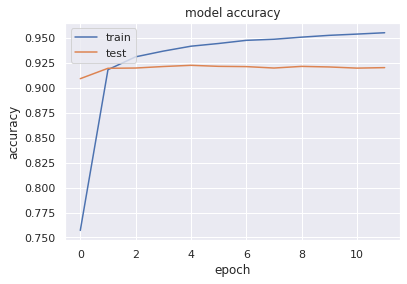

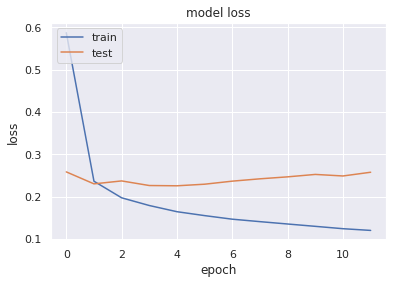

In [87]:
#Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Evaluasi Model with unseen data**

In [89]:
# Evaluating the model against the test data
results = model.evaluate(data_test, label_test, verbose=1);
print('Uji data menggunakan data yang tidak terlihat\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(results[0],results[1]))

875/875 [==============================] - 91s 104ms/step - loss: 0.2507 - accuracy: 0.9229
Uji data menggunakan data yang tidak terlihat
  Loss: 0.251
  Accuracy: 0.923
